In [2]:
import pandas as pd
import numpy as np

In [24]:
import matplotlib.pyplot as plt

In [3]:
emails = pd.read_csv('yammer_emails.csv')
events = pd.read_csv('yammer_events.csv')
users = pd.read_csv('yammer_users.csv')
rollup = pd.read_csv('dimension_rollup_periods.csv')

First, I want to take a look at our data in general and get a sense of what I'm working with.

I'll start with the emails table. What's in there, and what kind of actions are taken by email?

In [4]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [5]:
print(f'Email actions were: {emails.action.unique()}')
print(f'user types are: {emails.user_type.unique()}')

Email actions were: ['sent_weekly_digest' 'email_open' 'email_clickthrough'
 'sent_reengagement_email']
user types are: [1. 3. 2.]


Now, let's look at what's in events

In [6]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


Cool, there are a lot of different things that we can stratify on to see where the dip is coming from and if it's universal. Odds are that there's something in particular that's causing the decrease in engagement, and not an overall trend for everyone. But we'll have to test that hypothesis.

In [7]:
print(f'Event types are:{events.event_type.unique()}')
print(f'Event names are:{events.event_name.unique()}')
print(f'Locations are:{events.location.unique()}')

Event types are:['engagement' 'signup_flow']
Event names are:['login' 'home_page' 'like_message' 'view_inbox' 'search_run'
 'send_message' 'search_autocomplete' 'search_click_result_10'
 'create_user' 'enter_email' 'enter_info' 'complete_signup'
 'search_click_result_7' 'search_click_result_8' 'search_click_result_1'
 'search_click_result_3' 'search_click_result_2' 'search_click_result_5'
 'search_click_result_6' 'search_click_result_9' 'search_click_result_4']
Locations are:['Japan' 'Netherlands' 'Austria' 'Finland' 'United Kingdom' 'India'
 'United States' 'France' 'Iran' 'Germany' 'Australia' 'Brazil' 'Thailand'
 'Russia' 'Taiwan' 'Canada' 'Spain' 'Israel' 'Colombia' 'Iraq' 'Indonesia'
 'Greece' 'Norway' 'United Arab Emirates' 'Korea' 'Venezuela' 'Belgium'
 'Saudi Arabia' 'Poland' 'Sweden' 'Denmark' 'Mexico' 'Italy' 'Egypt'
 'Nigeria' 'Pakistan' 'Portugal' 'Singapore' 'South Africa' 'Hong Kong'
 'Switzerland' 'Turkey' 'Chile' 'Ireland' 'Argentina' 'Malaysia'
 'Philippines']


Cool, so we can see that we have two types of events, and we're dealing with a decrease in engagement type events.
Finally, let's get a look at what's in the users table before we get merging or further explore things.

In [8]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


This one looks pretty straightforward- userID, what language they speak, what company they are with, and when they activated (finished registering and started using Yammer?)

In [11]:
rollup.tail()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
55997,2007.0,2015-12-31 19:00:00,2015-12-24 19:00:00,2015-12-31 19:00:00,2015-12-25 03:00:00,2016-01-01 03:00:00
55998,2007.0,2015-12-31 20:00:00,2015-12-24 20:00:00,2015-12-31 20:00:00,2015-12-25 04:00:00,2016-01-01 04:00:00
55999,2007.0,2015-12-31 21:00:00,2015-12-24 21:00:00,2015-12-31 21:00:00,2015-12-25 05:00:00,2016-01-01 05:00:00
56000,2007.0,2015-12-31 22:00:00,2015-12-24 22:00:00,2015-12-31 22:00:00,2015-12-25 06:00:00,2016-01-01 06:00:00
56001,2007.0,2015-12-31 23:00:00,2015-12-24 23:00:00,2015-12-31 23:00:00,2015-12-25 07:00:00,2016-01-01 07:00:00


Ok, so now I've taken a look at what all we've got. I also went onto the Mode Analytics website where this chart was generated and pulled the SQL query so that I could know just what I'm looking at here.
```
SELECT DATE_TRUNC('week', e.occurred_at),
       COUNT(DISTINCT e.user_id) AS weekly_active_users
  FROM tutorial.yammer_events e
 WHERE e.event_type = 'engagement'
   AND e.event_name = 'login'
 GROUP BY 1
 ORDER BY 1
 ```
So, I'm no SQL expert, but this looks like it's not engagement, but just 'logins'. If it's just logins, we've got a different problem that we want to investigate. But I'm going to assume I don't know anything about SQL and that the underlying assumptions of the challege are correct- IE this is a drop in **engagement** and not just logins.

The data goes into the future, so we will use the 'occurred at' values to select only those that are in our time of interest

In [9]:
events.dtypes

user_id        float64
occurred_at     object
event_type      object
event_name      object
location        object
device          object
user_type      float64
dtype: object

Because the 'occurred_at' columns are objects, we won't be able to properly select them. Thus, we will change them into pandas datetime objects. 

In [10]:
events.occurred_at = pd.to_datetime(events.occurred_at)
emails.occurred_at = pd.to_datetime(events.occurred_at)

In [11]:
events_current = events[events['occurred_at']<pd.to_datetime('2014-9-2')]
emails_current = emails[emails['occurred_at']<pd.to_datetime('2014-9-2')]

In [12]:
# test = pd.merge(events_current, users, how='left', on='user_id')

# What could be happening?!? 

There are two likely culprits in this kind of case: First, something broke. If it's not that, then we might have a more complicated problem. It's also possible that this is just normal. Let's investigate the possibilities in a little more detail.

1. It's a seasonal variation and is totally normal
2. The website broke
3. The internet somewhere broke
4. We quit sending emails
5. We sent some offensive email
6. Nothing is wrong. It's literally just random noise



## Hypthesis 1 - It's nothing but a seasonal variation

In [27]:
## Hypothesis 1 - It's seasonal variation and nothing is wrong- we could look at the data from the
## previous year and see if a similar peak and dip occurred.
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


Well, unfotunately we don't have the data from last year to tell us if it's just a seasonal variation. We could ask someone else at the company, but let's assume that the boss was here last year and judging by his strong response to the graph, this isn't actually normal. Next hypothesis.

## Hypothesis 2: The website was down and people couldn't log in.

This one is a little hairy- we have the original data that says it's engagement, so if that's true then we want to know about logins specifically because those could be driving other engagement factors. A broken login means no one can engage in any other way. So we will test to see if log-ins preceded the drop in total engagement.

In [28]:
## The website broke. This means we would have seen a lot less log-ins than usual
logins = events_current[events_current['event_name']=='login']; logins.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
6,10612.0,2014-05-01 09:59:46,engagement,login,Netherlands,iphone 5,1.0
18,10736.0,2014-05-09 17:52:45,engagement,login,Austria,iphone 4s,2.0
21,10965.0,2014-05-15 13:52:59,engagement,login,Finland,windows surface,3.0
23,11020.0,2014-05-08 09:15:35,engagement,login,Japan,macbook air,2.0


In [29]:
by_loc = logins.groupby(by='location')

In [30]:
test = logins.groupby(by='occurred_at').location.value_counts()

In [31]:
ts = pd.Series(range(len(logins)), index=logins.occurred_at, )
# In [9]: idx = pd.date_range('2018-01-01', periods=5, freq='H')

In [32]:
# logins.occurred_at.resample('7D')
new = logins.set_index('occurred_at')

resamp = new.resample('W').nunique()

In [33]:
resamp = new.resample('W')['event_name'].value_counts()

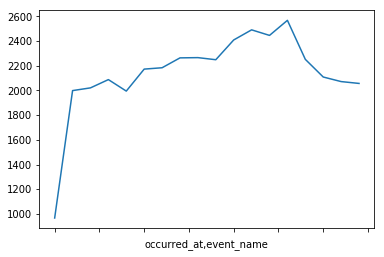

In [34]:
# plt.plot(x=resamp.index[0], y=resamp)
resamp.plot()

The above graph shows the number of logins, a specific type of engagement, by week. It looks pretty similar, but let's take a look at the numbers

In [35]:
resamp

occurred_at  event_name
2014-05-04   login          967
2014-05-11   login         1999
2014-05-18   login         2021
2014-05-25   login         2088
2014-06-01   login         1995
2014-06-08   login         2173
2014-06-15   login         2184
2014-06-22   login         2264
2014-06-29   login         2266
2014-07-06   login         2249
2014-07-13   login         2409
2014-07-20   login         2491
2014-07-27   login         2446
2014-08-03   login         2568
2014-08-10   login         2252
2014-08-17   login         2109
2014-08-24   login         2072
2014-08-31   login         2057
Name: event_name, dtype: int64

OK so this is kind of weird. We see the drop in engagement from the 27th to the 3rd, mostly. Then we see a decrease in logins the following week.
So it looks like it's very possible that something broke, people couldn't use the product, and then the didn't log in the next week because they thought it would still be down.
We can see that it wasn't a break in the ability to log in, which means that it was probably something with the functionality of the site.

In [48]:
# new['counts'] = logins.event_name.value_counts()
# let's look for each different type of event and see if any of them dropped to zero.

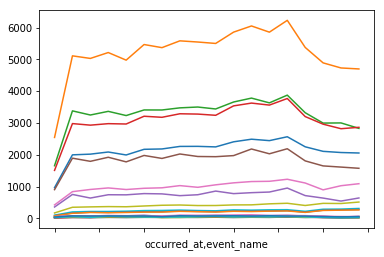

In [44]:
ev_tests = [events.event_name.unique()]
z=0
for name in ev_tests[0]:    
    stats = events_current[events_current['event_name']==name]
    new = stats.set_index('occurred_at')
    resamp = new.resample('W')['event_name'].value_counts()
    resamp.plot()

In [49]:
#I didn't put a key on here because this is a quick and dirty look, and then I dive into the numbers later
# This cell shows what categories are displayed on the above chart in the various colored lines.
print (ev_tests[0])

['login' 'home_page' 'like_message' 'view_inbox' 'search_run'
 'send_message' 'search_autocomplete' 'search_click_result_10'
 'create_user' 'enter_email' 'enter_info' 'complete_signup'
 'search_click_result_7' 'search_click_result_8' 'search_click_result_1'
 'search_click_result_3' 'search_click_result_2' 'search_click_result_5'
 'search_click_result_6' 'search_click_result_9' 'search_click_result_4']


According to the above graph, it looks like this drop in engagement wasn't caused by some certain part of the website breaking. We've looked into each separate engagement metric and none of them went to zero or gave any indication that they aren't working. We can look at the underlying numbers below, but they aren't promising.

In [47]:
ev_tests = [events.event_name.unique()]
z=0
for name in ev_tests[0]:    
    stats = events_current[events_current['event_name']==name]
    new = stats.set_index('occurred_at')
    resamp = new.resample('W')['event_name'].value_counts()
    print(resamp)

occurred_at  event_name
2014-05-04   login          967
2014-05-11   login         1999
2014-05-18   login         2021
2014-05-25   login         2088
2014-06-01   login         1995
2014-06-08   login         2173
2014-06-15   login         2184
2014-06-22   login         2264
2014-06-29   login         2266
2014-07-06   login         2249
2014-07-13   login         2409
2014-07-20   login         2491
2014-07-27   login         2446
2014-08-03   login         2568
2014-08-10   login         2252
2014-08-17   login         2109
2014-08-24   login         2072
2014-08-31   login         2057
Name: event_name, dtype: int64
occurred_at  event_name
2014-05-04   home_page     2546
2014-05-11   home_page     5113
2014-05-18   home_page     5032
2014-05-25   home_page     5217
2014-06-01   home_page     4978
2014-06-08   home_page     5469
2014-06-15   home_page     5371
2014-06-22   home_page     5585
2014-06-29   home_page     5548
2014-07-06   home_page     5503
2014-07-13   home_page   

occurred_at  event_name           
2014-05-04   search_click_result_5    26
2014-05-11   search_click_result_5    66
2014-05-18   search_click_result_5    43
2014-05-25   search_click_result_5    64
2014-06-01   search_click_result_5    67
2014-06-08   search_click_result_5    71
2014-06-15   search_click_result_5    52
2014-06-22   search_click_result_5    56
2014-06-29   search_click_result_5    64
2014-07-06   search_click_result_5    64
2014-07-13   search_click_result_5    61
2014-07-20   search_click_result_5    48
2014-07-27   search_click_result_5    65
2014-08-03   search_click_result_5    56
2014-08-10   search_click_result_5    53
2014-08-17   search_click_result_5    41
2014-08-24   search_click_result_5    36
2014-08-31   search_click_result_5    35
Name: event_name, dtype: int64
occurred_at  event_name           
2014-05-04   search_click_result_6    41
2014-05-11   search_click_result_6    49
2014-05-18   search_click_result_6    35
2014-05-25   search_click_result_6    

## Hypothesis 3: The internet broke somewhere


In [64]:
# events_current.set_index('occurred_at', inplace=True)
locs=events_current.groupby(by='location')
resamp = locs.resample('W')#['location'].value_counts()

In [65]:
locs.head()

,user_id,event_type,event_name,location,device,user_type
occurred_at,,,,,,
2014-05-02 11:02:39,10522.0,engagement,login,Japan,dell inspiron notebook,3.0
2014-05-02 11:02:53,10522.0,engagement,home_page,Japan,dell inspiron notebook,3.0
2014-05-02 11:03:28,10522.0,engagement,like_message,Japan,dell inspiron notebook,3.0
2014-05-02 11:04:09,10522.0,engagement,view_inbox,Japan,dell inspiron notebook,3.0
2014-05-02 11:03:16,10522.0,engagement,search_run,Japan,dell inspiron notebook,3.0
2014-05-01 09:59:46,10612.0,engagement,login,Netherlands,iphone 5,1.0
2014-05-01 10:00:18,10612.0,engagement,like_message,Netherlands,iphone 5,1.0
2014-05-01 10:00:53,10612.0,engagement,send_message,Netherlands,iphone 5,1.0
2014-05-01 10:01:24,10612.0,engagement,home_page,Netherlands,iphone 5,1.0
